In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import os
import zipfile
from sklearn.model_selection import train_test_split
from PIL import Image
from torchvision import transforms
import time
import matplotlib.pyplot as plt


In [ ]:
def extract_zip(zip_file_path, extract_to='/content/'):
    """
    Extracts a ZIP file to the specified directory.
    """
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    print("ZIP file extracted to", extract_to)

def parse_pairs_file(file_path):
    """
    Parses a pairs file (e.g., pairsDevTrain.txt or pairsDevTest.txt).
    """
    data_txt = []
    with open(file_path, 'r') as f:
        num_same_pairs = int(f.readline().strip())  # First line indicates the number of same pairs
        for line in f:
            line = line.strip().split()
            data_txt.append(line)
    return data_txt, num_same_pairs

def generate_image_paths(data_txt, base_dir):
    """
    Generates image paths and labels based on the parsed data from a pairs file.
    """
    img_paths = []
    for lst in data_txt:
        if len(lst) == 3:  # Same person
            name = lst[0]
            img1_path = os.path.join(base_dir, name, f"{name}_{int(lst[1]):04d}.jpg")
            img2_path = os.path.join(base_dir, name, f"{name}_{int(lst[2]):04d}.jpg")
            label = 1
        elif len(lst) == 4:  # Different person
            name1 = lst[0]
            img1_path = os.path.join(base_dir, name1, f"{name1}_{int(lst[1]):04d}.jpg")
            name2 = lst[2]
            img2_path = os.path.join(base_dir, name2, f"{name2}_{int(lst[3]):04d}.jpg")
            label = 0
        else:
            continue
        img_paths.append([img1_path, img2_path, label])
    return img_paths

def calculate_statistics(data_txt, num_same_pairs):
    """
    Calculates and prints dataset statistics.
    """
    total_samples = len(data_txt)
    num_diff_pairs = total_samples - num_same_pairs
    return total_samples, num_same_pairs, num_diff_pairs

zip_file_path = '/content/lfwa.zip'
extract_zip(zip_file_path)

# Base directory for images
base_dir = '/content/lfw2/lfw2'

# Train dataset
train_pairs_file = 'pairsDevTrain.txt'
train_data_txt, same_people_train = parse_pairs_file(train_pairs_file)
img_path_train = generate_image_paths(train_data_txt, base_dir)

# Test dataset
test_pairs_file = 'pairsDevTest.txt'
test_data_txt, same_people_test = parse_pairs_file(test_pairs_file)
img_path_test = generate_image_paths(test_data_txt, base_dir)

# Calculate statistics
total_train_samples, diff_people_train = calculate_statistics(train_data_txt, same_people_train)[0:3:2]
total_test_samples, diff_people_test = calculate_statistics(test_data_txt, same_people_test)[0:3:2]
total_samples = total_train_samples + total_test_samples

# Print statistics
print("Dataset Statistics:")
print("--------------------")
print(f"Total number of samples: {total_samples}")
print(f"Number of samples in the Train Set: {total_train_samples}")
print(f"Number of same people in the Train Set: {same_people_train}")
print(f"Number of different people in the Train Set: {diff_people_train}")
print(f"Number of samples in the Test Set: {total_test_samples}")
print(f"Number of same people in the Test Set: {same_people_test}")
print(f"Number of different people in the Test Set: {diff_people_test}")


ZIP file extracted to /content/
Dataset Statistics:
--------------------
Total number of samples: 3200
Number of samples in the Train Set: 2200
Number of same people in the Train Set: 1100
Number of different people in the Train Set: 1100
Number of samples in the Test Set: 1000
Number of same people in the Test Set: 500
Number of different people in the Test Set: 500


In [ ]:
# Define transformations
transform = transforms.Compose([
    transforms.Resize((105, 105)),  # Resize to 105x105
    transforms.ToTensor(),  # Convert to tensor
])


# Function to preprocess an image
def preprocess_image(image_path):
    try:
        image = Image.open(image_path).convert("RGB")  # Open image in RGB format
        return transform(image)
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        return None


# Preprocess dataset
def preprocess_dataset(dataset):
    processed_data = []
    for img1_path, img2_path, label in dataset:
        img1 = preprocess_image(img1_path)
        img2 = preprocess_image(img2_path)
        if img1 is not None and img2 is not None:  # Only keep valid pairs
            processed_data.append((img1, img2, label))
    return processed_data


# Create the datasets
train_set = preprocess_dataset(img_path_train)
test_set = preprocess_dataset(img_path_test)


train, val = train_test_split(train_set, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Number of training samples: {len(train)}")
print(f"Number of validation samples: {len(val)}")
print(f"Number of test samples: {len(test_set)}")



Number of training samples: 1760
Number of validation samples: 440
Number of test samples: 1000


In [ ]:
# Create DataLoaders
train_loader_32 = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test_loader_32 = torch.utils.data.DataLoader(test_set, batch_size=32, shuffle=False)
val_loader_32 = torch.utils.data.DataLoader(val, batch_size=32, shuffle=False)

# Create DataLoaders
train_loader_64 = torch.utils.data.DataLoader(train, batch_size=64, shuffle=True)
test_loader_64 = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)
val_loader_64 = torch.utils.data.DataLoader(val, batch_size=64, shuffle=False)
# Create DataLoaders
train_loader_128 = torch.utils.data.DataLoader(train, batch_size=128, shuffle=True)
test_loader_128 = torch.utils.data.DataLoader(test_set, batch_size=128, shuffle=False)
val_loader_128 = torch.utils.data.DataLoader(val, batch_size=128, shuffle=False)

# Create DataLoaders
train_loader_256 = torch.utils.data.DataLoader(train, batch_size=256, shuffle=True)
test_loader_256 = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False)
val_loader_256 = torch.utils.data.DataLoader(val, batch_size=256, shuffle=False)

Experiment 1: Batch size = 128 check the first model

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 64 @ 48x48

            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 21x21

            nn.Conv2d(128, 128, kernel_size=4, stride=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 9x9

            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.ReLU(inplace=True),                  # Output: 256 @ 6x6
        )

        self.fc1 = nn.Linear(256 * 6 * 6, 4096)  # Fully connected layer: 4096
        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def flatten_one(self, input):
        """
        Flattens the input tensor into (batch_size, -1).
        """
        return input.view(input.size(0), -1)

    def forward(self, one, two):
        # Forward pass through CNN
        output1 = self.cnn(one)
        output2 = self.cnn(two)

        # Flatten the outputs
        output1 = self.flatten_one(output1)
        output2 = self.flatten_one(output2)

        # Pass through the first fully connected layer
        output1 = self.fc1(output1)
        output2 = self.fc1(output2)

        # Compute absolute difference and pass through final FC layer
        similarity = self.fc2(torch.abs(output1 - output2))
        return similarity



Running Experiment with batch_size=128, learning_rate=0.0001
Epoch 1/20 - training_loss: 0.6875 - training_accuracy: 0.5080 - validation_loss: 0.6806 - validation_accuracy: 0.4955
Epoch 2/20 - training_loss: 0.6556 - training_accuracy: 0.5693 - validation_loss: 0.6727 - validation_accuracy: 0.5886
Epoch 3/20 - training_loss: 0.6109 - training_accuracy: 0.6767 - validation_loss: 0.6443 - validation_accuracy: 0.6523
Epoch 4/20 - training_loss: 0.5694 - training_accuracy: 0.7080 - validation_loss: 0.6110 - validation_accuracy: 0.6545
Epoch 5/20 - training_loss: 0.5178 - training_accuracy: 0.7540 - validation_loss: 0.6302 - validation_accuracy: 0.6409
Epoch 6/20 - training_loss: 0.4600 - training_accuracy: 0.7966 - validation_loss: 0.6701 - validation_accuracy: 0.6636
Epoch 7/20 - training_loss: 0.3979 - training_accuracy: 0.8244 - validation_loss: 0.7051 - validation_accuracy: 0.6545
Epoch 8/20 - training_loss: 0.3035 - training_accuracy: 0.8784 - validation_loss: 0.7994 - validation_acc

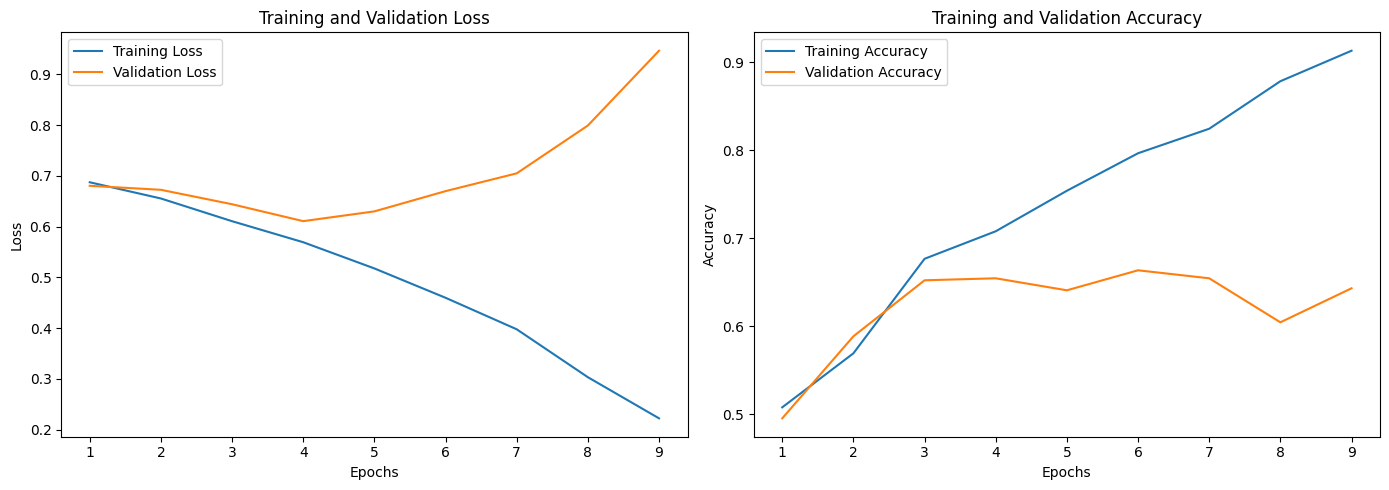

In [ ]:
# Experiment parameters
batch_size = 128
learning_rate = 0.0001
num_epochs = 20
early_stop_patience = 5

print(f"\nRunning Experiment with batch_size={batch_size}, learning_rate={learning_rate}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set DataLoaders for batch size 128
train_loader = train_loader_128
test_loader = test_loader_128
val_loader = val_loader_128

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Start training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    training_correct = 0
    training_total = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        preds = (outputs >= 0.5).float()
        training_correct += (torch.flatten(preds) == label).float().sum()
        training_total += label.size(0)

    training_loss /= len(train_loader)
    training_accuracy = training_correct / len(train_loader.dataset)
    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy.cpu().item())

    # Validation
    model.eval()
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            validation_loss += loss.item()
            preds = (outputs >= 0.5).float()
            validation_correct += (torch.flatten(preds) == label).float().sum()
            validation_total += label.size(0)

    validation_loss /= len(val_loader)
    validation_accuracy = validation_correct / len(val_loader.dataset)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy.cpu().item())

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - training_loss: {training_loss:.4f} - training_accuracy: {training_accuracy:.4f} "
          f"- validation_loss: {validation_loss:.4f} - validation_accuracy: {validation_accuracy:.4f}")

    # Early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'siamese_best_model_bs{batch_size}_lr{learning_rate}.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

end_time = time.time()
print(f"Experiment completed in {end_time - start_time:.2f} seconds")

# Test Evaluation
print("Evaluating on Test Data...")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        test_correct += (torch.flatten(preds) == label).float().sum()
        test_total += label.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

# Plot Training and Validation Metrics
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(epochs, train_losses, label="Training Loss")
axes[0].plot(epochs, val_losses, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Accuracy
axes[1].plot(epochs, train_accuracies, label="Training Accuracy")
axes[1].plot(epochs, val_accuracies, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


Experiment 2: Compare Adam and SGD using batch size = 128 like article


Running Experiment with SGD and batch_size=128
Epoch 1/20 - SGD - training_loss: 0.6931 - training_accuracy: 0.5045 - validation_loss: 0.6931 - validation_accuracy: 0.4841
Epoch 2/20 - SGD - training_loss: 0.6929 - training_accuracy: 0.5040 - validation_loss: 0.6931 - validation_accuracy: 0.4841
Epoch 3/20 - SGD - training_loss: 0.6927 - training_accuracy: 0.5040 - validation_loss: 0.6930 - validation_accuracy: 0.4841
Epoch 4/20 - SGD - training_loss: 0.6925 - training_accuracy: 0.5040 - validation_loss: 0.6928 - validation_accuracy: 0.4841
Epoch 5/20 - SGD - training_loss: 0.6921 - training_accuracy: 0.5040 - validation_loss: 0.6924 - validation_accuracy: 0.4841
Epoch 6/20 - SGD - training_loss: 0.6915 - training_accuracy: 0.5040 - validation_loss: 0.6918 - validation_accuracy: 0.4841
Epoch 7/20 - SGD - training_loss: 0.6904 - training_accuracy: 0.5040 - validation_loss: 0.6907 - validation_accuracy: 0.4841
Epoch 8/20 - SGD - training_loss: 0.6890 - training_accuracy: 0.5040 - valida

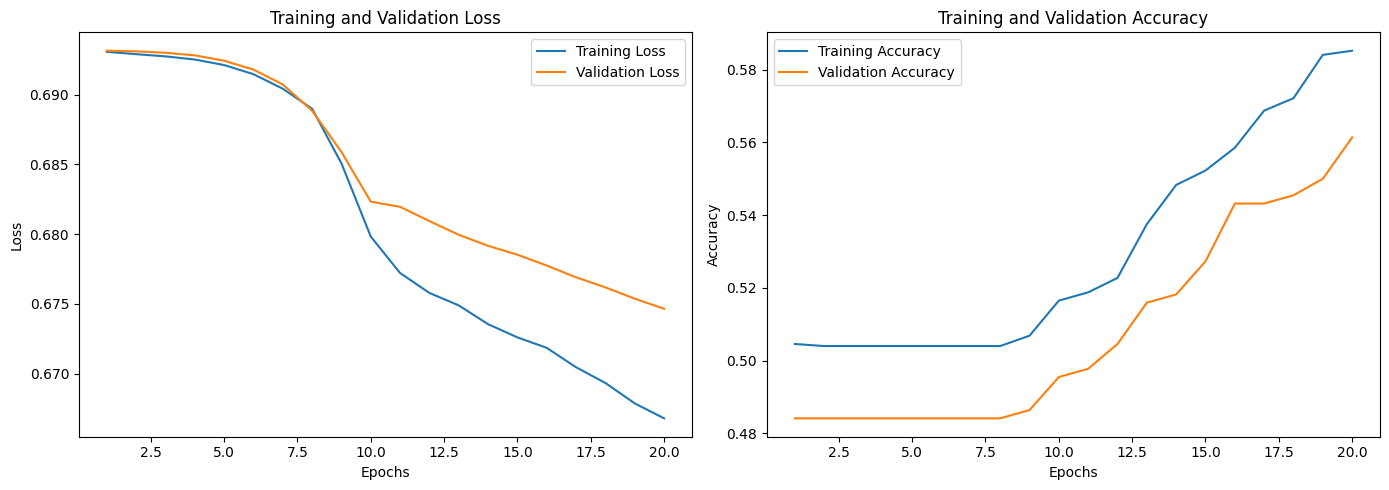

In [ ]:
# Experiment configurations
batch_size = 128
sgd_lr = 0.01
num_epochs = 20
early_stop_patience = 5

print(f"\nRunning Experiment with SGD and batch_size={batch_size}")

# Initialize model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=sgd_lr, momentum=0.9)  # Use SGD optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set DataLoaders for the current batch size
train_loader = train_loader_128
test_loader = test_loader_128
val_loader = val_loader_128

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Start training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    training_correct = 0
    training_total = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        preds = (outputs >= 0.5).float()
        training_correct += (torch.flatten(preds) == label).float().sum()
        training_total += label.size(0)

    training_loss /= len(train_loader)
    training_accuracy = training_correct / len(train_loader.dataset)
    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy.cpu().item())

    # Validation
    model.eval()
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            validation_loss += loss.item()
            preds = (outputs >= 0.5).float()
            validation_correct += (torch.flatten(preds) == label).float().sum()
            validation_total += label.size(0)

    validation_loss /= len(val_loader)
    validation_accuracy = validation_correct / len(val_loader.dataset)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy.cpu().item())

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - SGD - training_loss: {training_loss:.4f} - training_accuracy: {training_accuracy:.4f} "
          f"- validation_loss: {validation_loss:.4f} - validation_accuracy: {validation_accuracy:.4f}")

    # Early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'siamese_best_model_SGD_bs{batch_size}.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

end_time = time.time()
print(f"Experiment with SGD completed in {end_time - start_time:.2f} seconds")

# Test Evaluation
print("Evaluating on Test Data with SGD...")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        test_correct += (torch.flatten(preds) == label).float().sum()
        test_total += label.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

# Plot Training and Validation Metrics
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(epochs, train_losses, label="Training Loss")
axes[0].plot(epochs, val_losses, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Accuracy
axes[1].plot(epochs, train_accuracies, label="Training Accuracy")
axes[1].plot(epochs, val_accuracies, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


experiment3: Add Batch Normalization


Running Experiment with learning_rate=0.0001, batch_size=128 (no dropout)
Epoch 1/20 - learning_rate=0.0001 - training_loss: 0.7079 - training_accuracy: 0.5733 - validation_loss: 0.6767 - validation_accuracy: 0.6045
Epoch 2/20 - learning_rate=0.0001 - training_loss: 0.2374 - training_accuracy: 0.9534 - validation_loss: 0.6063 - validation_accuracy: 0.6750
Epoch 3/20 - learning_rate=0.0001 - training_loss: 0.0854 - training_accuracy: 0.9989 - validation_loss: 0.6377 - validation_accuracy: 0.6750
Epoch 4/20 - learning_rate=0.0001 - training_loss: 0.0362 - training_accuracy: 1.0000 - validation_loss: 0.6264 - validation_accuracy: 0.6727
Epoch 5/20 - learning_rate=0.0001 - training_loss: 0.0188 - training_accuracy: 1.0000 - validation_loss: 0.6273 - validation_accuracy: 0.6909
Epoch 6/20 - learning_rate=0.0001 - training_loss: 0.0120 - training_accuracy: 1.0000 - validation_loss: 0.6300 - validation_accuracy: 0.6955
Epoch 7/20 - learning_rate=0.0001 - training_loss: 0.0090 - training_accu

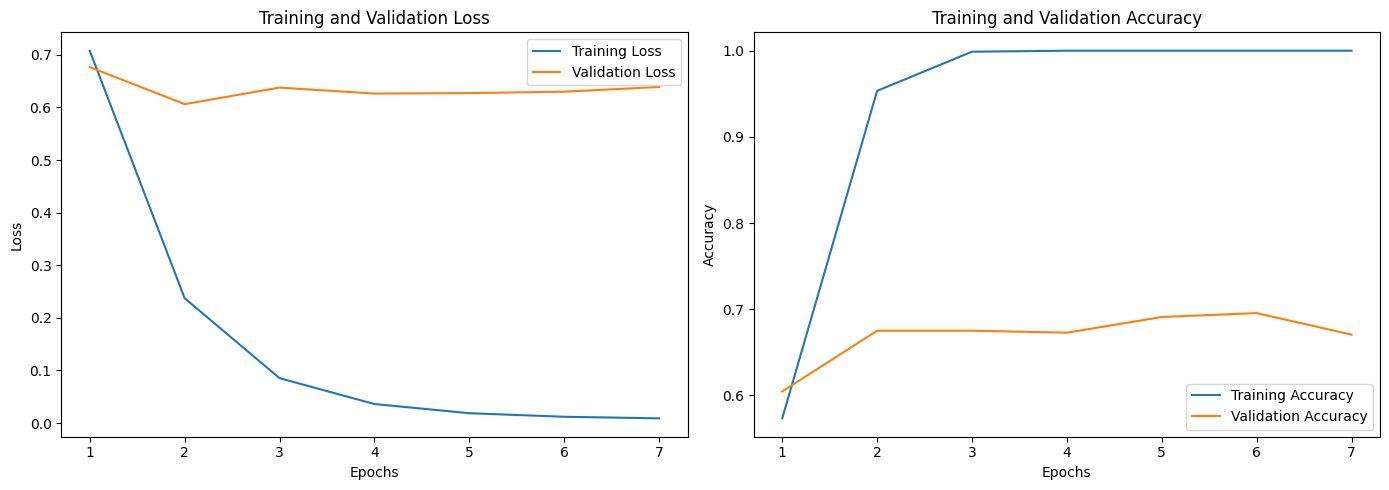

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 64 @ 48x48

            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 21x21

            nn.Conv2d(128, 128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 9x9

            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)  # Final convolutional block
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def flatten_one(self, input):
        """
        Flattens the input tensor into (batch_size, -1).
        """
        return input.view(input.size(0), -1)

    def forward(self, one, two):
        # Forward pass through CNN
        output1 = self.cnn(one)
        output2 = self.cnn(two)

        # Flatten the outputs
        output1 = self.flatten_one(output1)
        output2 = self.flatten_one(output2)

        # Pass through the first fully connected layer
        output1 = self.fc1(output1)
        output2 = self.fc1(output2)

        # Compute absolute difference and pass through final FC layer
        similarity = self.fc2(torch.abs(output1 - output2))
        return similarity


# Experiment parameters
learning_rate = 0.0001
batch_size = 128
num_epochs = 20
early_stop_patience = 5

print(f"\nRunning Experiment with learning_rate={learning_rate}, batch_size={batch_size} (no dropout)")

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Set DataLoaders for the current batch size
train_loader = train_loader_128
test_loader = test_loader_128
val_loader = val_loader_128

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# Lists to store metrics for plotting
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

# Start training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    training_correct = 0
    training_total = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        preds = (outputs >= 0.5).float()
        training_correct += (torch.flatten(preds) == label).float().sum()
        training_total += label.size(0)

    training_loss /= len(train_loader)
    training_accuracy = training_correct / len(train_loader.dataset)
    train_losses.append(training_loss)
    train_accuracies.append(training_accuracy.cpu().item())

    # Validation
    model.eval()
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            validation_loss += loss.item()
            preds = (outputs >= 0.5).float()
            validation_correct += (torch.flatten(preds) == label).float().sum()
            validation_total += label.size(0)

    validation_loss /= len(val_loader)
    validation_accuracy = validation_correct / len(val_loader.dataset)
    val_losses.append(validation_loss)
    val_accuracies.append(validation_accuracy.cpu().item())

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - learning_rate={learning_rate} - training_loss: {training_loss:.4f} - training_accuracy: {training_accuracy:.4f} "
          f"- validation_loss: {validation_loss:.4f} - validation_accuracy: {validation_accuracy:.4f}")

    # Early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'siamese_best_model_no_dropout_lr{learning_rate}.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

end_time = time.time()
print(f"Experiment with learning_rate={learning_rate} completed in {end_time - start_time:.2f} seconds")

# Test Evaluation
print(f"Evaluating on Test Data with learning_rate={learning_rate}...")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        test_correct += (torch.flatten(preds) == label).float().sum()
        test_total += label.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")

# Plot Training and Validation Metrics
epochs = range(1, len(train_losses) + 1)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot Loss
axes[0].plot(epochs, train_losses, label="Training Loss")
axes[0].plot(epochs, val_losses, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Plot Accuracy
axes[1].plot(epochs, train_accuracies, label="Training Accuracy")
axes[1].plot(epochs, val_accuracies, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()


experiment4: Add Dropout

In [ ]:
# Model class with dropout
class SiameseNetwork(nn.Module):
    def __init__(self, dropout_rate):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(128, 128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(dropout_rate),

            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout_rate)
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def flatten_one(self, input):
        return input.view(input.size(0), -1)

    def forward(self, one, two):
        output1 = self.cnn(one)
        output2 = self.cnn(two)

        output1 = self.flatten_one(output1)
        output2 = self.flatten_one(output2)

        output1 = self.fc1(output1)
        output2 = self.fc1(output2)

        similarity = self.fc2(torch.abs(output1 - output2))
        return similarity


Running Experiment with dropout_rate=0.1, learning_rate=0.0001, batch_size=128
Epoch 1/20 - train_loss: 0.7130 - train_acc: 0.5449 - val_loss: 0.6833 - val_acc: 0.5455
Epoch 2/20 - train_loss: 0.5662 - train_acc: 0.7233 - val_loss: 0.6848 - val_acc: 0.5659
Epoch 3/20 - train_loss: 0.4470 - train_acc: 0.8102 - val_loss: 0.6632 - val_acc: 0.6068
Epoch 4/20 - train_loss: 0.3693 - train_acc: 0.8631 - val_loss: 0.6471 - val_acc: 0.6523
Epoch 5/20 - train_loss: 0.2917 - train_acc: 0.9205 - val_loss: 0.6163 - val_acc: 0.6614
Epoch 6/20 - train_loss: 0.2304 - train_acc: 0.9608 - val_loss: 0.6358 - val_acc: 0.6477
Epoch 7/20 - train_loss: 0.1877 - train_acc: 0.9699 - val_loss: 0.6196 - val_acc: 0.6909
Epoch 8/20 - train_loss: 0.1428 - train_acc: 0.9886 - val_loss: 0.6286 - val_acc: 0.6886
Epoch 9/20 - train_loss: 0.1183 - train_acc: 0.9903 - val_loss: 0.6488 - val_acc: 0.6523
Epoch 10/20 - train_loss: 0.0974 - train_acc: 0.9977 - val_loss: 0.6577 - val_acc: 0.6795
Early stopping triggered!
Exp

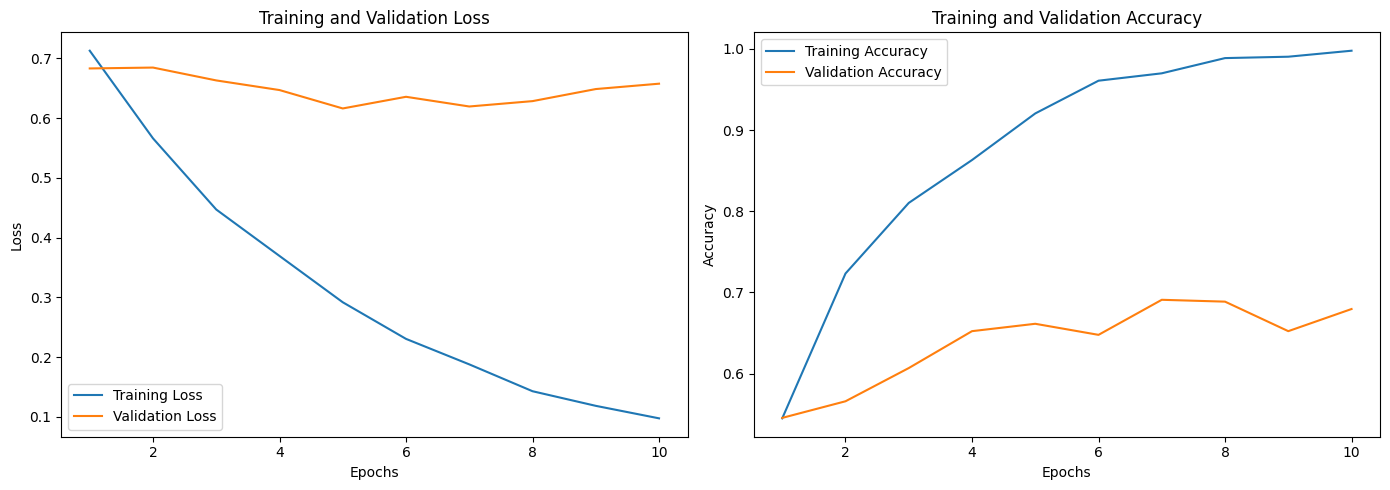

Evaluating on Test Data...
Test Loss: 0.6487 - Test Accuracy: 0.6630


In [ ]:
# Experiment parameters
dropout_rate = 0.1
learning_rate = 0.0001
batch_size = 128
num_epochs = 20
early_stop_patience = 5

# Loaders for batch size 128
train_loader = train_loader_128
val_loader = val_loader_128
test_loader = test_loader_128

print(f"\nRunning Experiment with dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(dropout_rate).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# Metrics for plotting
training_losses, validation_losses = [], []
training_accuracies, validation_accuracies = [], []

# Start training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    training_correct = 0
    training_total = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        preds = (outputs >= 0.5).float()
        training_correct += (torch.flatten(preds) == label).float().sum()
        training_total += label.size(0)

    training_loss /= len(train_loader)
    training_accuracy = (training_correct / len(train_loader.dataset)).cpu().item()  # Move to CPU and convert to float
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    # Validation
    model.eval()
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            validation_loss += loss.item()
            preds = (outputs >= 0.5).float()
            validation_correct += (torch.flatten(preds) == label).float().sum()
            validation_total += label.size(0)

    validation_loss /= len(val_loader)
    validation_accuracy = (validation_correct / len(val_loader.dataset)).cpu().item()  # Move to CPU and convert to float
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"train_loss: {training_loss:.4f} - train_acc: {training_accuracy:.4f} - "
          f"val_loss: {validation_loss:.4f} - val_acc: {validation_accuracy:.4f}")

    # Early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'siamese_best_model_dropout{dropout_rate}_lr{learning_rate}.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

end_time = time.time()
print(f"Experiment completed in {end_time - start_time:.2f} seconds")

# Plot Results
epochs = range(1, len(training_losses) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training and Validation Loss
axes[0].plot(epochs, training_losses, label="Training Loss")
axes[0].plot(epochs, validation_losses, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Training and Validation Accuracy
axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# Test Evaluation
print("Evaluating on Test Data...")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        test_correct += (torch.flatten(preds) == label).float().sum()
        test_total += label.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")



Running Experiment with dropout_rate=0.2, learning_rate=0.0001, batch_size=128
Epoch 1/20 - train_loss: 0.7234 - train_acc: 0.5347 - val_loss: 0.6898 - val_acc: 0.4864
Epoch 2/20 - train_loss: 0.6738 - train_acc: 0.5966 - val_loss: 0.6569 - val_acc: 0.5841
Epoch 3/20 - train_loss: 0.6003 - train_acc: 0.6659 - val_loss: 0.6508 - val_acc: 0.5818
Epoch 4/20 - train_loss: 0.5585 - train_acc: 0.7170 - val_loss: 0.6280 - val_acc: 0.6318
Epoch 5/20 - train_loss: 0.5047 - train_acc: 0.7500 - val_loss: 0.6509 - val_acc: 0.6136
Epoch 6/20 - train_loss: 0.4676 - train_acc: 0.7909 - val_loss: 0.6718 - val_acc: 0.6114
Epoch 7/20 - train_loss: 0.4194 - train_acc: 0.8261 - val_loss: 0.6265 - val_acc: 0.6727
Epoch 8/20 - train_loss: 0.3744 - train_acc: 0.8534 - val_loss: 0.6750 - val_acc: 0.6432
Epoch 9/20 - train_loss: 0.3544 - train_acc: 0.8642 - val_loss: 0.6411 - val_acc: 0.6500
Epoch 10/20 - train_loss: 0.3350 - train_acc: 0.8687 - val_loss: 0.6484 - val_acc: 0.6545
Epoch 11/20 - train_loss: 0.2

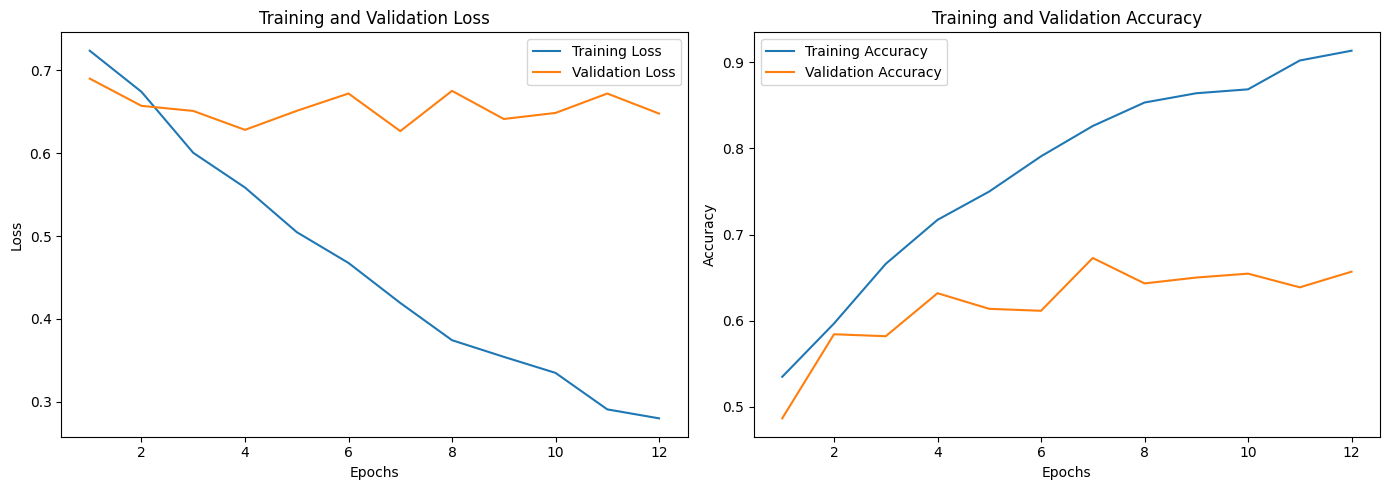

Evaluating on Test Data...
Test Loss: 0.6524 - Test Accuracy: 0.6350


In [ ]:
# Experiment parameters
dropout_rate = 0.2
learning_rate = 0.0001
batch_size = 128
num_epochs = 20
early_stop_patience = 5

# Loaders for batch size 128
train_loader = train_loader_128
val_loader = val_loader_128
test_loader = test_loader_128

print(f"\nRunning Experiment with dropout_rate={dropout_rate}, learning_rate={learning_rate}, batch_size={batch_size}")

# Initialize model, loss, optimizer, and scheduler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork(dropout_rate).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Early stopping variables
best_val_loss = float('inf')
patience_counter = 0

# Metrics for plotting
training_losses, validation_losses = [], []
training_accuracies, validation_accuracies = [], []

# Start training
start_time = time.time()
for epoch in range(num_epochs):
    model.train()
    training_loss = 0
    training_correct = 0
    training_total = 0

    for img1, img2, label in train_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        loss.backward()
        optimizer.step()
        training_loss += loss.item()
        preds = (outputs >= 0.5).float()
        training_correct += (torch.flatten(preds) == label).float().sum()
        training_total += label.size(0)

    training_loss /= len(train_loader)
    training_accuracy = (training_correct / len(train_loader.dataset)).cpu().item()  # Move to CPU and convert to float
    training_losses.append(training_loss)
    training_accuracies.append(training_accuracy)

    # Validation
    model.eval()
    validation_loss = 0
    validation_correct = 0
    validation_total = 0
    with torch.no_grad():
        for img1, img2, label in val_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            validation_loss += loss.item()
            preds = (outputs >= 0.5).float()
            validation_correct += (torch.flatten(preds) == label).float().sum()
            validation_total += label.size(0)

    validation_loss /= len(val_loader)
    validation_accuracy = (validation_correct / len(val_loader.dataset)).cpu().item()  # Move to CPU and convert to float
    validation_losses.append(validation_loss)
    validation_accuracies.append(validation_accuracy)

    # Print metrics
    print(f"Epoch {epoch + 1}/{num_epochs} - "
          f"train_loss: {training_loss:.4f} - train_acc: {training_accuracy:.4f} - "
          f"val_loss: {validation_loss:.4f} - val_acc: {validation_accuracy:.4f}")

    # Early stopping
    if validation_loss < best_val_loss:
        best_val_loss = validation_loss
        patience_counter = 0
        torch.save(model.state_dict(), f'siamese_best_model_dropout{dropout_rate}_lr{learning_rate}.pth')
    else:
        patience_counter += 1
        if patience_counter >= early_stop_patience:
            print("Early stopping triggered!")
            break

    scheduler.step()

end_time = time.time()
print(f"Experiment completed in {end_time - start_time:.2f} seconds")

# Plot Results
epochs = range(1, len(training_losses) + 1)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Training and Validation Loss
axes[0].plot(epochs, training_losses, label="Training Loss")
axes[0].plot(epochs, validation_losses, label="Validation Loss")
axes[0].set_title("Training and Validation Loss")
axes[0].set_xlabel("Epochs")
axes[0].set_ylabel("Loss")
axes[0].legend()

# Training and Validation Accuracy
axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
axes[1].set_title("Training and Validation Accuracy")
axes[1].set_xlabel("Epochs")
axes[1].set_ylabel("Accuracy")
axes[1].legend()

plt.tight_layout()
plt.show()

# Test Evaluation
print("Evaluating on Test Data...")
model.eval()
test_loss = 0
test_correct = 0
test_total = 0
with torch.no_grad():
    for img1, img2, label in test_loader:
        img1, img2, label = img1.to(device), img2.to(device), label.to(device)
        outputs = model(img1, img2)
        loss = criterion(outputs.float(), label.unsqueeze(1).float())
        test_loss += loss.item()
        preds = (outputs >= 0.5).float()
        test_correct += (torch.flatten(preds) == label).float().sum()
        test_total += label.size(0)

test_loss /= len(test_loader)
test_accuracy = test_correct / test_total

print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")


Experiment 5: Added L2 regularization, tested 4 experiments with different batch sizes (32, 64, 128, 256) and 3 weight decay values (1e-4, 1e-5, 1e-6).

In [ ]:
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=10, stride=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 64 @ 48x48

            nn.Conv2d(64, 128, kernel_size=7, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 21x21

            nn.Conv2d(128, 128, kernel_size=4, stride=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2),  # Output: 128 @ 9x9

            nn.Conv2d(128, 256, kernel_size=4, stride=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)  # Final convolutional block
        )

        self.fc1 = nn.Sequential(
            nn.Linear(256 * 6 * 6, 4096),
            nn.BatchNorm1d(4096),
            nn.ReLU(),
        )

        self.fc2 = nn.Sequential(
            nn.Linear(4096, 1),
            nn.Sigmoid()
        )

    def flatten_one(self, input):
        """
        Flattens the input tensor into (batch_size, -1).
        """
        return input.view(input.size(0), -1)

    def forward(self, one, two):
        # Forward pass through CNN
        output1 = self.cnn(one)
        output2 = self.cnn(two)

        # Flatten the outputs
        output1 = self.flatten_one(output1)
        output2 = self.flatten_one(output2)

        # Pass through the first fully connected layer
        output1 = self.fc1(output1)
        output2 = self.fc1(output2)

        # Compute absolute difference and pass through final FC layer
        similarity = self.fc2(torch.abs(output1 - output2))
        return similarity


Running Experiment with weight_decay=0.0001, learning_rate=0.0001, batch_size=256
Epoch 1/20 - weight_decay=0.0001 - training_loss: 0.7015 - training_accuracy: 0.5693 - validation_loss: 0.6914 - validation_accuracy: 0.5864
Epoch 2/20 - weight_decay=0.0001 - training_loss: 0.2276 - training_accuracy: 0.9750 - validation_loss: 0.6708 - validation_accuracy: 0.5932
Epoch 3/20 - weight_decay=0.0001 - training_loss: 0.0955 - training_accuracy: 0.9989 - validation_loss: 0.6104 - validation_accuracy: 0.6409
Epoch 4/20 - weight_decay=0.0001 - training_loss: 0.0484 - training_accuracy: 1.0000 - validation_loss: 0.5919 - validation_accuracy: 0.6659
Epoch 5/20 - weight_decay=0.0001 - training_loss: 0.0263 - training_accuracy: 1.0000 - validation_loss: 0.5981 - validation_accuracy: 0.6591
Epoch 6/20 - weight_decay=0.0001 - training_loss: 0.0170 - training_accuracy: 1.0000 - validation_loss: 0.6118 - validation_accuracy: 0.6750
Epoch 7/20 - weight_decay=0.0001 - training_loss: 0.0120 - training_acc

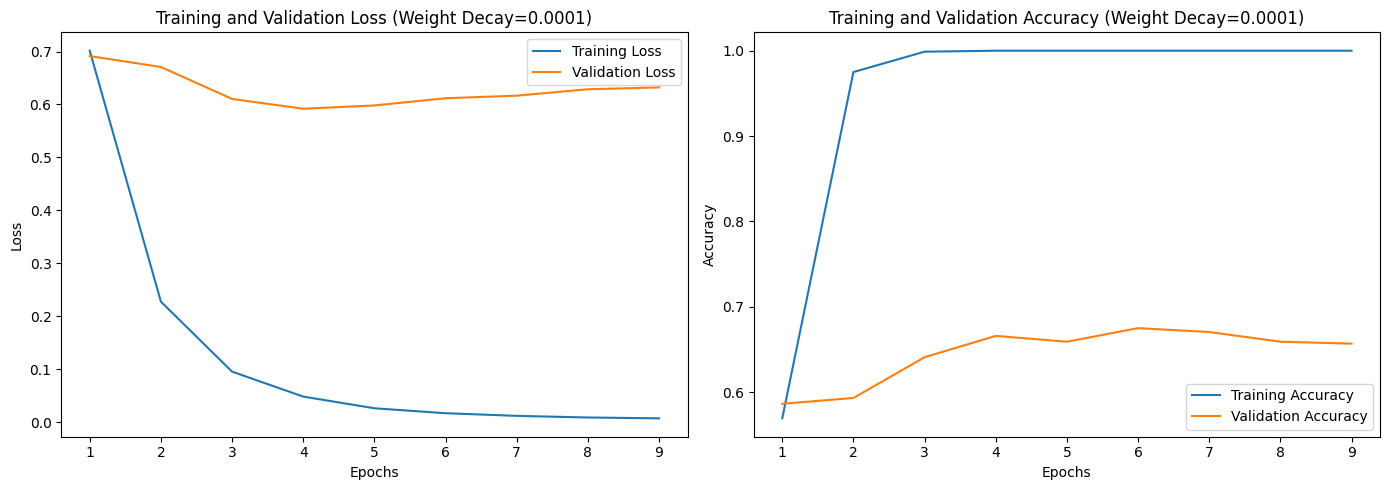

Evaluating on Test Data with weight_decay=0.0001...
Test Loss: 0.6170 - Test Accuracy: 0.6730

Running Experiment with weight_decay=1e-05, learning_rate=0.0001, batch_size=256
Epoch 1/20 - weight_decay=1e-05 - training_loss: 0.6956 - training_accuracy: 0.5642 - validation_loss: 0.6923 - validation_accuracy: 0.5159
Epoch 2/20 - weight_decay=1e-05 - training_loss: 0.2169 - training_accuracy: 0.9727 - validation_loss: 0.6758 - validation_accuracy: 0.6068
Epoch 3/20 - weight_decay=1e-05 - training_loss: 0.0888 - training_accuracy: 0.9994 - validation_loss: 0.6147 - validation_accuracy: 0.6636
Epoch 4/20 - weight_decay=1e-05 - training_loss: 0.0415 - training_accuracy: 1.0000 - validation_loss: 0.5942 - validation_accuracy: 0.6977
Epoch 5/20 - weight_decay=1e-05 - training_loss: 0.0228 - training_accuracy: 1.0000 - validation_loss: 0.5998 - validation_accuracy: 0.6977
Epoch 6/20 - weight_decay=1e-05 - training_loss: 0.0137 - training_accuracy: 1.0000 - validation_loss: 0.6042 - validation_a

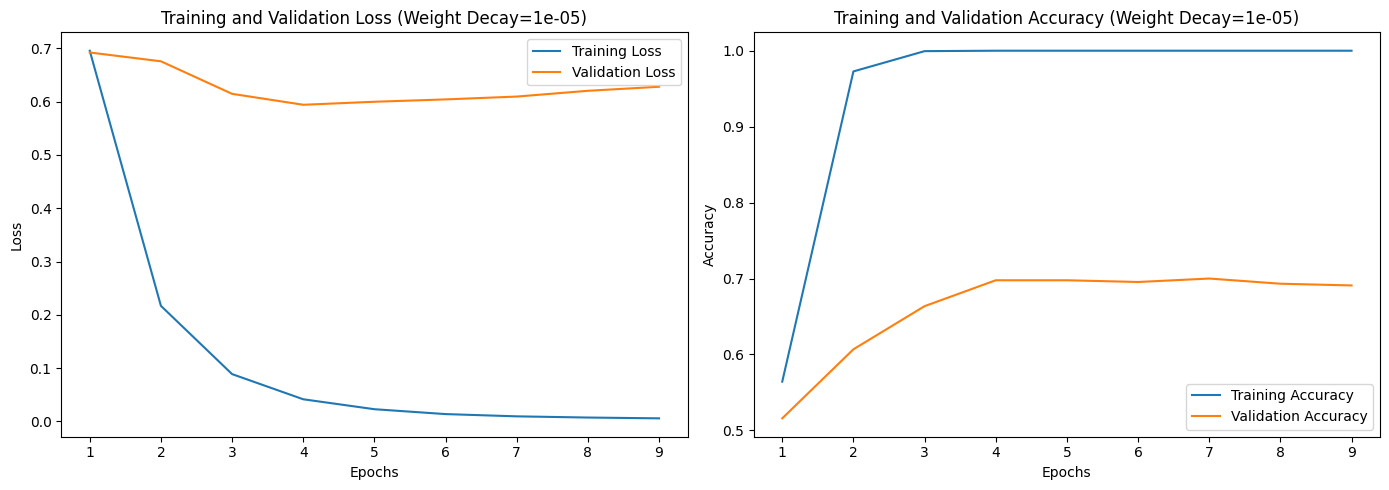

Evaluating on Test Data with weight_decay=1e-05...
Test Loss: 0.6293 - Test Accuracy: 0.6680

Running Experiment with weight_decay=1e-06, learning_rate=0.0001, batch_size=256
Epoch 1/20 - weight_decay=1e-06 - training_loss: 0.7071 - training_accuracy: 0.5551 - validation_loss: 0.6914 - validation_accuracy: 0.5000
Epoch 2/20 - weight_decay=1e-06 - training_loss: 0.2332 - training_accuracy: 0.9642 - validation_loss: 0.6780 - validation_accuracy: 0.5841
Epoch 3/20 - weight_decay=1e-06 - training_loss: 0.0965 - training_accuracy: 0.9989 - validation_loss: 0.6188 - validation_accuracy: 0.6659
Epoch 4/20 - weight_decay=1e-06 - training_loss: 0.0468 - training_accuracy: 1.0000 - validation_loss: 0.6075 - validation_accuracy: 0.6750
Epoch 5/20 - weight_decay=1e-06 - training_loss: 0.0253 - training_accuracy: 1.0000 - validation_loss: 0.6104 - validation_accuracy: 0.6955
Epoch 6/20 - weight_decay=1e-06 - training_loss: 0.0151 - training_accuracy: 1.0000 - validation_loss: 0.6258 - validation_ac

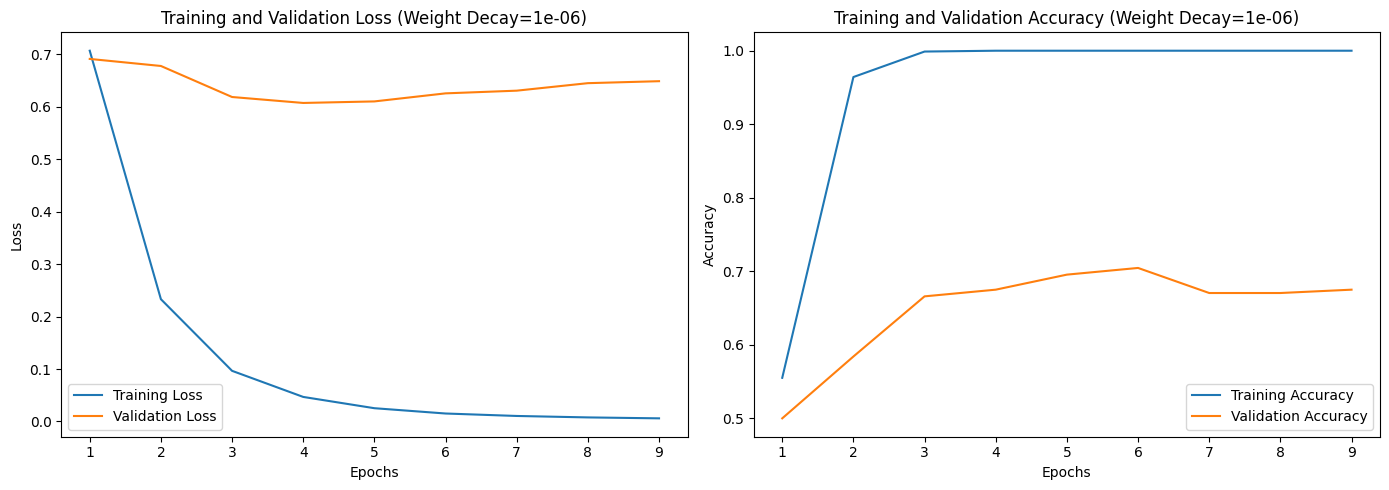

Evaluating on Test Data with weight_decay=1e-06...
Test Loss: 0.6212 - Test Accuracy: 0.6830


In [ ]:
# Experiment parameters
learning_rate = 0.0001
batch_size = 256
num_epochs = 20
early_stop_patience = 5
weight_decays = [1e-4, 1e-5, 1e-6]  # Different weight decay values for L2 Regularization

# Set DataLoaders for the current batch size
train_loader = train_loader_256
test_loader = test_loader_256
val_loader = val_loader_256

for weight_decay in weight_decays:
    print(f"\nRunning Experiment with weight_decay={weight_decay}, learning_rate={learning_rate}, batch_size={batch_size}")

    # Initialize model, loss, optimizer, and scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SiameseNetwork().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    # Metrics for plotting
    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []

    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct = 0
        training_total = 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            preds = (outputs >= 0.5).float()
            training_correct += (torch.flatten(preds) == label).float().sum()
            training_total += label.size(0)

        training_loss /= len(train_loader)
        training_accuracy = (training_correct / len(train_loader.dataset)).cpu().item()
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)

        # Validation
        model.eval()
        validation_loss = 0
        validation_correct = 0
        validation_total = 0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs.float(), label.unsqueeze(1).float())
                validation_loss += loss.item()
                preds = (outputs >= 0.5).float()
                validation_correct += (torch.flatten(preds) == label).float().sum()
                validation_total += label.size(0)

        validation_loss /= len(val_loader)
        validation_accuracy = (validation_correct / len(val_loader.dataset)).cpu().item()
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Print metrics
        print(f"Epoch {epoch + 1}/{num_epochs} - weight_decay={weight_decay} - "
              f"training_loss: {training_loss:.4f} - training_accuracy: {training_accuracy:.4f} - "
              f"validation_loss: {validation_loss:.4f} - validation_accuracy: {validation_accuracy:.4f}")

        # Early stopping
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'siamese_best_model_weight_decay_256_{weight_decay}.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

        scheduler.step()

    end_time = time.time()
    print(f"Experiment with weight_decay={weight_decay} completed in {end_time - start_time:.2f} seconds")

    # Plot Results
    epochs = range(1, len(training_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training and Validation Loss
    axes[0].plot(epochs, training_losses, label="Training Loss")
    axes[0].plot(epochs, validation_losses, label="Validation Loss")
    axes[0].set_title(f"Training and Validation Loss (Weight Decay={weight_decay})")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Training and Validation Accuracy
    axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
    axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
    axes[1].set_title(f"Training and Validation Accuracy (Weight Decay={weight_decay})")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Test Evaluation
    print(f"Evaluating on Test Data with weight_decay={weight_decay}...")
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (torch.flatten(preds) == label).float().sum()
            test_total += label.size(0)

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")



Running Experiment with weight_decay=0.0001, learning_rate=0.0001, batch_size=128
Epoch 1/20 - weight_decay=0.0001 - train_loss: 0.6783 - train_acc: 0.5784 - val_loss: 0.6779 - val_acc: 0.6068
Epoch 2/20 - weight_decay=0.0001 - train_loss: 0.2119 - train_acc: 0.9705 - val_loss: 0.6222 - val_acc: 0.6773
Epoch 3/20 - weight_decay=0.0001 - train_loss: 0.0771 - train_acc: 0.9989 - val_loss: 0.6138 - val_acc: 0.6795
Epoch 4/20 - weight_decay=0.0001 - train_loss: 0.0305 - train_acc: 1.0000 - val_loss: 0.6150 - val_acc: 0.6932
Epoch 5/20 - weight_decay=0.0001 - train_loss: 0.0161 - train_acc: 1.0000 - val_loss: 0.6254 - val_acc: 0.6841
Epoch 6/20 - weight_decay=0.0001 - train_loss: 0.0107 - train_acc: 1.0000 - val_loss: 0.6362 - val_acc: 0.6841
Epoch 7/20 - weight_decay=0.0001 - train_loss: 0.0078 - train_acc: 1.0000 - val_loss: 0.6440 - val_acc: 0.6818
Epoch 8/20 - weight_decay=0.0001 - train_loss: 0.0062 - train_acc: 1.0000 - val_loss: 0.6484 - val_acc: 0.6818
Early stopping triggered!
Exp

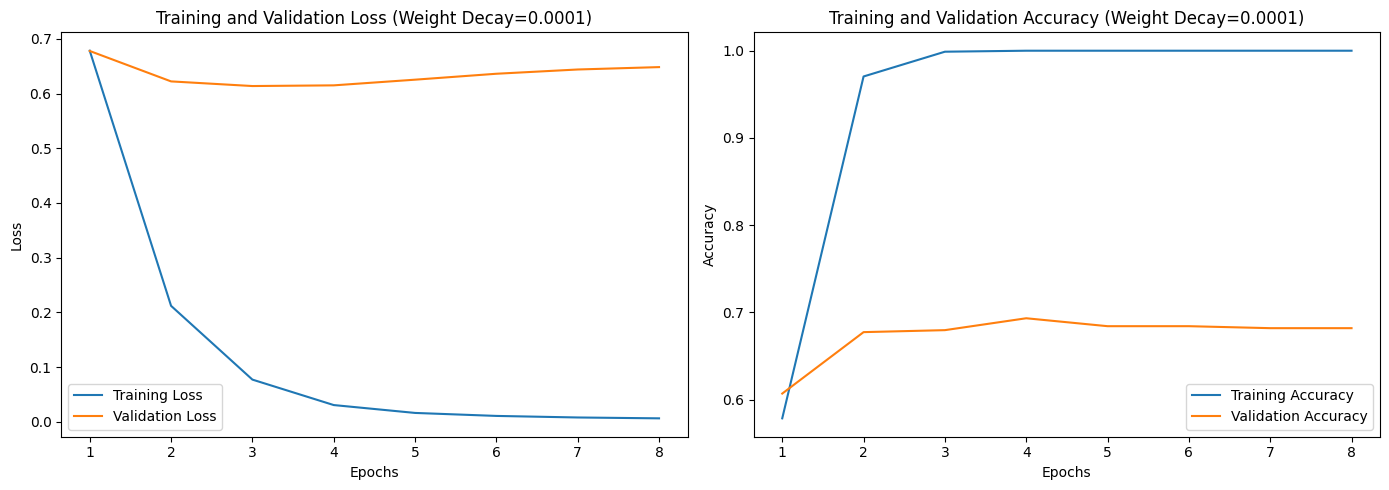

Evaluating on Test Data with weight_decay=0.0001...
Test Loss: 0.6146 - Test Accuracy: 0.6960

Running Experiment with weight_decay=1e-05, learning_rate=0.0001, batch_size=128
Epoch 1/20 - weight_decay=1e-05 - train_loss: 0.7049 - train_acc: 0.5676 - val_loss: 0.6685 - val_acc: 0.5727
Epoch 2/20 - weight_decay=1e-05 - train_loss: 0.2621 - train_acc: 0.9364 - val_loss: 0.5903 - val_acc: 0.6773
Epoch 3/20 - weight_decay=1e-05 - train_loss: 0.0969 - train_acc: 0.9972 - val_loss: 0.6082 - val_acc: 0.6795
Epoch 4/20 - weight_decay=1e-05 - train_loss: 0.0380 - train_acc: 1.0000 - val_loss: 0.6052 - val_acc: 0.6705
Epoch 5/20 - weight_decay=1e-05 - train_loss: 0.0193 - train_acc: 1.0000 - val_loss: 0.6146 - val_acc: 0.6841
Epoch 6/20 - weight_decay=1e-05 - train_loss: 0.0121 - train_acc: 1.0000 - val_loss: 0.6276 - val_acc: 0.6727
Epoch 7/20 - weight_decay=1e-05 - train_loss: 0.0088 - train_acc: 1.0000 - val_loss: 0.6284 - val_acc: 0.6886
Early stopping triggered!
Experiment with weight_decay

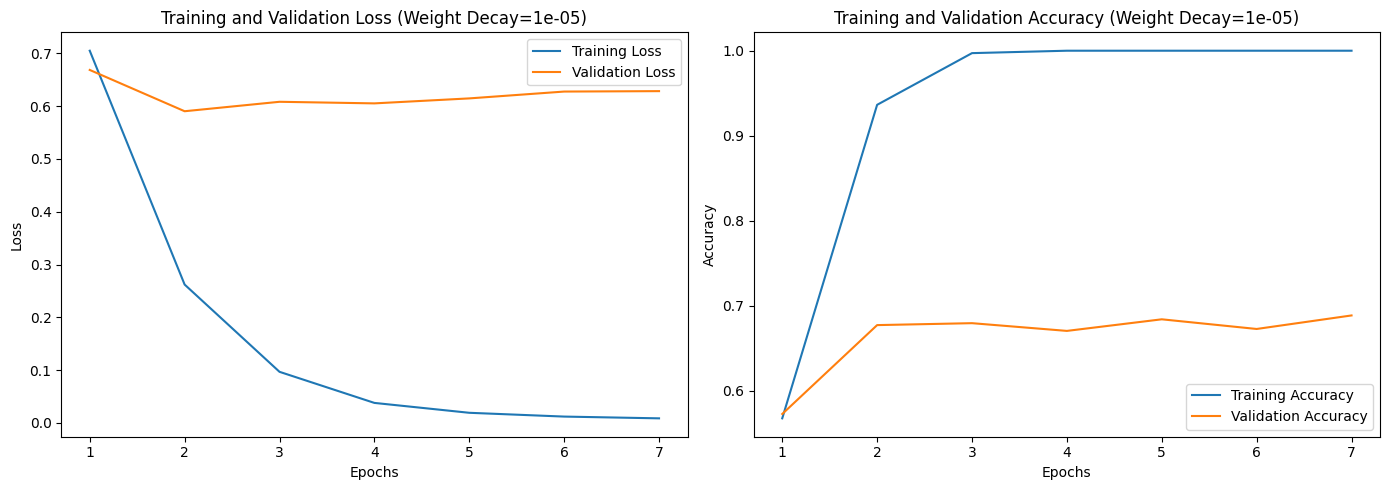

Evaluating on Test Data with weight_decay=1e-05...
Test Loss: 0.6016 - Test Accuracy: 0.6900

Running Experiment with weight_decay=1e-06, learning_rate=0.0001, batch_size=128
Epoch 1/20 - weight_decay=1e-06 - train_loss: 0.6967 - train_acc: 0.5869 - val_loss: 0.6733 - val_acc: 0.5750
Epoch 2/20 - weight_decay=1e-06 - train_loss: 0.2690 - train_acc: 0.9347 - val_loss: 0.6433 - val_acc: 0.6409
Epoch 3/20 - weight_decay=1e-06 - train_loss: 0.1051 - train_acc: 0.9983 - val_loss: 0.6082 - val_acc: 0.7000
Epoch 4/20 - weight_decay=1e-06 - train_loss: 0.0449 - train_acc: 1.0000 - val_loss: 0.5968 - val_acc: 0.7068
Epoch 5/20 - weight_decay=1e-06 - train_loss: 0.0221 - train_acc: 1.0000 - val_loss: 0.6107 - val_acc: 0.6932
Epoch 6/20 - weight_decay=1e-06 - train_loss: 0.0136 - train_acc: 1.0000 - val_loss: 0.6197 - val_acc: 0.6932
Epoch 7/20 - weight_decay=1e-06 - train_loss: 0.0097 - train_acc: 1.0000 - val_loss: 0.6254 - val_acc: 0.6909
Epoch 8/20 - weight_decay=1e-06 - train_loss: 0.0075 - 

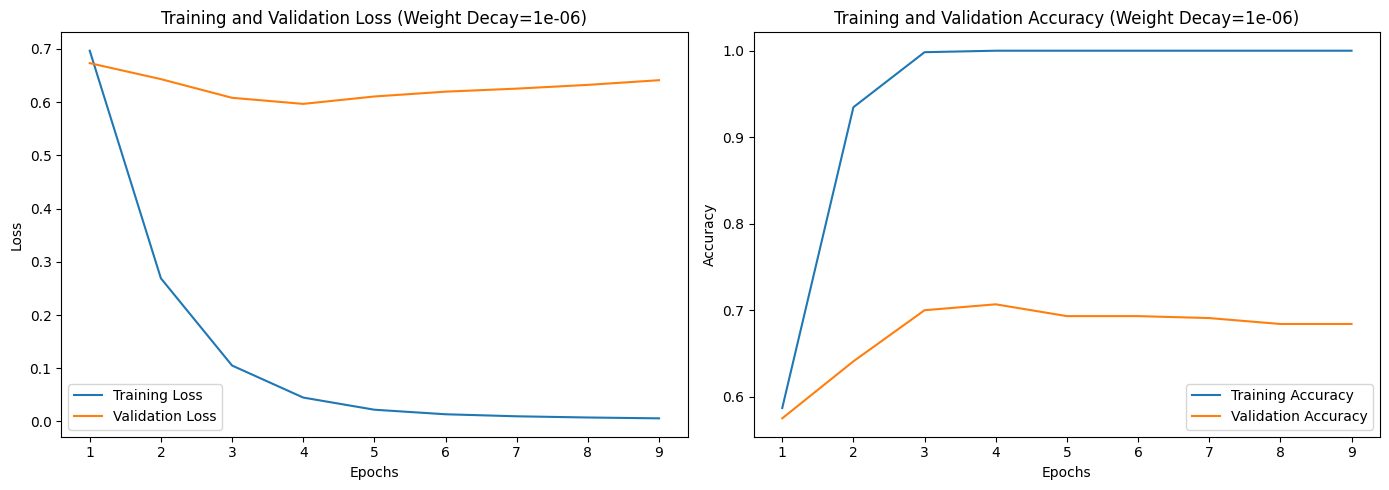

Evaluating on Test Data with weight_decay=1e-06...
Test Loss: 0.6117 - Test Accuracy: 0.6750


In [ ]:
# Experiment parameters
learning_rate = 0.0001
batch_size = 128
num_epochs = 20
early_stop_patience = 5
weight_decays = [1e-4, 1e-5, 1e-6]  # Different weight decay values for L2 Regularization

# Set DataLoaders for the current batch size
train_loader = train_loader_128
test_loader = test_loader_128
val_loader = val_loader_128

for weight_decay in weight_decays:
    print(f"\nRunning Experiment with weight_decay={weight_decay}, learning_rate={learning_rate}, batch_size={batch_size}")

    # Initialize model, loss, optimizer, and scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SiameseNetwork().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    # Metrics for plotting
    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []

    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct = 0
        training_total = 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            preds = (outputs >= 0.5).float()
            training_correct += (torch.flatten(preds) == label).float().sum()
            training_total += label.size(0)

        training_loss /= len(train_loader)
        training_accuracy = (training_correct / len(train_loader.dataset)).cpu().item()
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)

        # Validation
        model.eval()
        validation_loss = 0
        validation_correct = 0
        validation_total = 0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs.float(), label.unsqueeze(1).float())
                validation_loss += loss.item()
                preds = (outputs >= 0.5).float()
                validation_correct += (torch.flatten(preds) == label).float().sum()
                validation_total += label.size(0)

        validation_loss /= len(val_loader)
        validation_accuracy = (validation_correct / len(val_loader.dataset)).cpu().item()
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Print metrics
        print(f"Epoch {epoch + 1}/{num_epochs} - weight_decay={weight_decay} - "
              f"train_loss: {training_loss:.4f} - train_acc: {training_accuracy:.4f} - "
              f"val_loss: {validation_loss:.4f} - val_acc: {validation_accuracy:.4f}")

        # Early stopping
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'siamese_best_model_weight_decay_128_{weight_decay}.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

        scheduler.step()

    end_time = time.time()
    print(f"Experiment with weight_decay={weight_decay} completed in {end_time - start_time:.2f} seconds")

    # Plot Results
    epochs = range(1, len(training_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training and Validation Loss
    axes[0].plot(epochs, training_losses, label="Training Loss")
    axes[0].plot(epochs, validation_losses, label="Validation Loss")
    axes[0].set_title(f"Training and Validation Loss (Weight Decay={weight_decay})")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Training and Validation Accuracy
    axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
    axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
    axes[1].set_title(f"Training and Validation Accuracy (Weight Decay={weight_decay})")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Test Evaluation
    print(f"Evaluating on Test Data with weight_decay={weight_decay}...")
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (torch.flatten(preds) == label).float().sum()
            test_total += label.size(0)

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")



Running Experiment with weight_decay=0.0001, learning_rate=0.0001, batch_size=64
Epoch 1/20 - weight_decay=0.0001 - train_loss: 0.7218 - train_acc: 0.5625 - val_loss: 0.7083 - val_acc: 0.5795
Epoch 2/20 - weight_decay=0.0001 - train_loss: 0.2709 - train_acc: 0.9318 - val_loss: 0.6081 - val_acc: 0.6636
Epoch 3/20 - weight_decay=0.0001 - train_loss: 0.0936 - train_acc: 0.9994 - val_loss: 0.6310 - val_acc: 0.6818
Epoch 4/20 - weight_decay=0.0001 - train_loss: 0.0331 - train_acc: 1.0000 - val_loss: 0.6084 - val_acc: 0.6795
Epoch 5/20 - weight_decay=0.0001 - train_loss: 0.0167 - train_acc: 1.0000 - val_loss: 0.6286 - val_acc: 0.6773
Epoch 6/20 - weight_decay=0.0001 - train_loss: 0.0111 - train_acc: 1.0000 - val_loss: 0.6488 - val_acc: 0.6659
Epoch 7/20 - weight_decay=0.0001 - train_loss: 0.0083 - train_acc: 1.0000 - val_loss: 0.6441 - val_acc: 0.6773
Early stopping triggered!
Experiment with weight_decay=0.0001 completed in 43.17 seconds


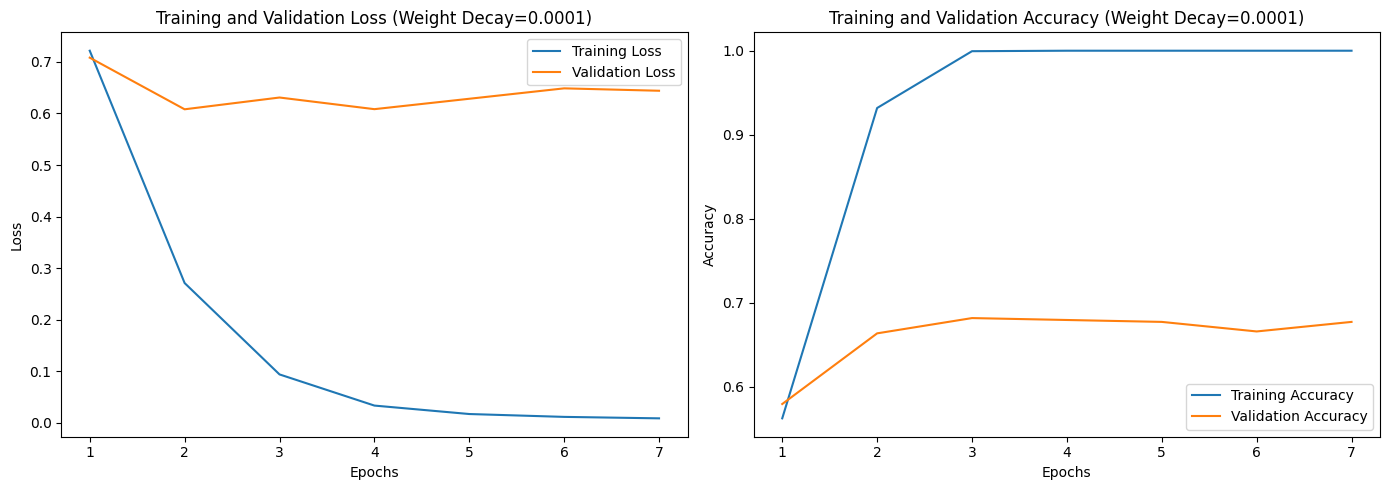

Evaluating on Test Data with weight_decay=0.0001...
Test Loss: 0.6343 - Test Accuracy: 0.6720

Running Experiment with weight_decay=1e-05, learning_rate=0.0001, batch_size=64
Epoch 1/20 - weight_decay=1e-05 - train_loss: 0.7043 - train_acc: 0.5659 - val_loss: 0.6835 - val_acc: 0.6341
Epoch 2/20 - weight_decay=1e-05 - train_loss: 0.2771 - train_acc: 0.9176 - val_loss: 0.6554 - val_acc: 0.6636
Epoch 3/20 - weight_decay=1e-05 - train_loss: 0.1010 - train_acc: 0.9955 - val_loss: 0.6247 - val_acc: 0.6909
Epoch 4/20 - weight_decay=1e-05 - train_loss: 0.0348 - train_acc: 0.9994 - val_loss: 0.6336 - val_acc: 0.6932
Epoch 5/20 - weight_decay=1e-05 - train_loss: 0.0166 - train_acc: 1.0000 - val_loss: 0.6419 - val_acc: 0.6773
Epoch 6/20 - weight_decay=1e-05 - train_loss: 0.0105 - train_acc: 1.0000 - val_loss: 0.6601 - val_acc: 0.6818
Epoch 7/20 - weight_decay=1e-05 - train_loss: 0.0072 - train_acc: 1.0000 - val_loss: 0.6627 - val_acc: 0.6886
Epoch 8/20 - weight_decay=1e-05 - train_loss: 0.0058 - 

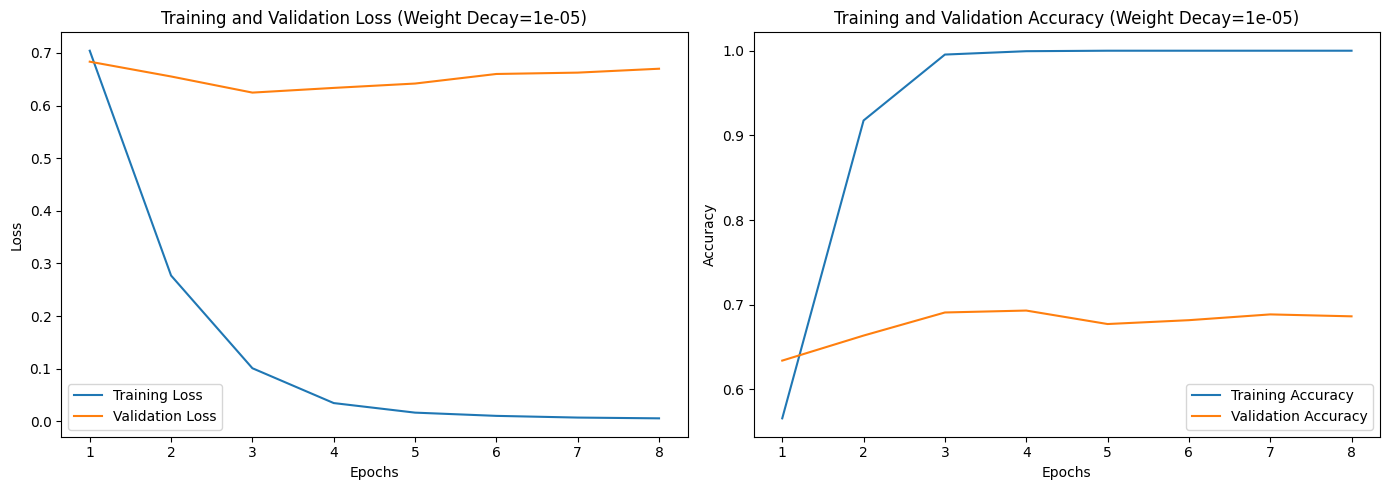

Evaluating on Test Data with weight_decay=1e-05...
Test Loss: 0.6684 - Test Accuracy: 0.6740

Running Experiment with weight_decay=1e-06, learning_rate=0.0001, batch_size=64
Epoch 1/20 - weight_decay=1e-06 - train_loss: 0.7002 - train_acc: 0.5722 - val_loss: 0.6647 - val_acc: 0.6000
Epoch 2/20 - weight_decay=1e-06 - train_loss: 0.2637 - train_acc: 0.9284 - val_loss: 0.6191 - val_acc: 0.6568
Epoch 3/20 - weight_decay=1e-06 - train_loss: 0.0881 - train_acc: 0.9977 - val_loss: 0.6327 - val_acc: 0.6864
Epoch 4/20 - weight_decay=1e-06 - train_loss: 0.0314 - train_acc: 1.0000 - val_loss: 0.6301 - val_acc: 0.6750
Epoch 5/20 - weight_decay=1e-06 - train_loss: 0.0157 - train_acc: 1.0000 - val_loss: 0.6447 - val_acc: 0.6818
Epoch 6/20 - weight_decay=1e-06 - train_loss: 0.0105 - train_acc: 1.0000 - val_loss: 0.6504 - val_acc: 0.6750
Epoch 7/20 - weight_decay=1e-06 - train_loss: 0.0082 - train_acc: 1.0000 - val_loss: 0.6622 - val_acc: 0.6750
Early stopping triggered!
Experiment with weight_decay=1

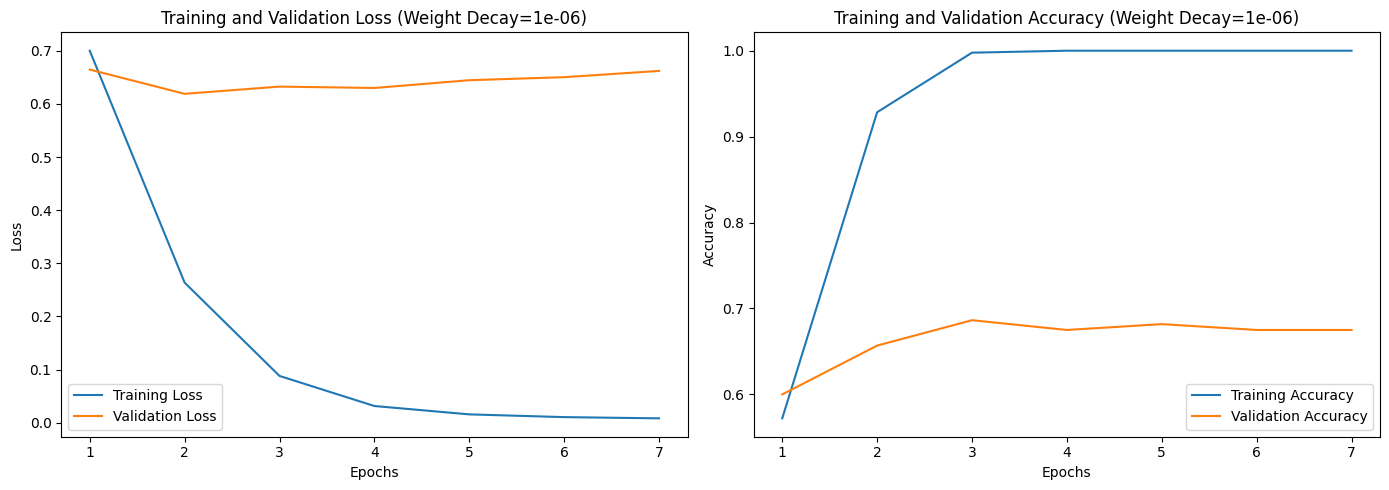

Evaluating on Test Data with weight_decay=1e-06...
Test Loss: 0.6343 - Test Accuracy: 0.6870


In [ ]:
# Experiment parameters
learning_rate = 0.0001
batch_size = 64
num_epochs = 20
early_stop_patience = 5
weight_decays = [1e-4, 1e-5, 1e-6]  # Different weight decay values for L2 Regularization

# Set DataLoaders for the current batch size
train_loader = train_loader_64
test_loader = test_loader_64
val_loader = val_loader_64

for weight_decay in weight_decays:
    print(f"\nRunning Experiment with weight_decay={weight_decay}, learning_rate={learning_rate}, batch_size={batch_size}")

    # Initialize model, loss, optimizer, and scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SiameseNetwork().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    # Metrics for plotting
    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []

    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct = 0
        training_total = 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            preds = (outputs >= 0.5).float()
            training_correct += (torch.flatten(preds) == label).float().sum()
            training_total += label.size(0)

        training_loss /= len(train_loader)
        training_accuracy = (training_correct / len(train_loader.dataset)).cpu().item()
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy)

        # Validation
        model.eval()
        validation_loss = 0
        validation_correct = 0
        validation_total = 0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs.float(), label.unsqueeze(1).float())
                validation_loss += loss.item()
                preds = (outputs >= 0.5).float()
                validation_correct += (torch.flatten(preds) == label).float().sum()
                validation_total += label.size(0)

        validation_loss /= len(val_loader)
        validation_accuracy = (validation_correct / len(val_loader.dataset)).cpu().item()
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy)

        # Print metrics
        print(f"Epoch {epoch + 1}/{num_epochs} - weight_decay={weight_decay} - "
              f"train_loss: {training_loss:.4f} - train_acc: {training_accuracy:.4f} - "
              f"val_loss: {validation_loss:.4f} - val_acc: {validation_accuracy:.4f}")

        # Early stopping
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'siamese_best_model_weight_decay_64_{weight_decay}.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

        scheduler.step()

    end_time = time.time()
    print(f"Experiment with weight_decay={weight_decay} completed in {end_time - start_time:.2f} seconds")

    # Plot Results
    epochs = range(1, len(training_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training and Validation Loss
    axes[0].plot(epochs, training_losses, label="Training Loss")
    axes[0].plot(epochs, validation_losses, label="Validation Loss")
    axes[0].set_title(f"Training and Validation Loss (Weight Decay={weight_decay})")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Training and Validation Accuracy
    axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
    axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
    axes[1].set_title(f"Training and Validation Accuracy (Weight Decay={weight_decay})")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Test Evaluation
    print(f"Evaluating on Test Data with weight_decay={weight_decay}...")
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (torch.flatten(preds) == label).float().sum()
            test_total += label.size(0)

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")



Running Experiment with weight_decay=0.0001, learning_rate=0.0001, batch_size=32
Epoch 1/20 - weight_decay=0.0001 - train_loss: 0.6942 - train_acc: 0.6051 - val_loss: 0.7768 - val_acc: 0.5932
Epoch 2/20 - weight_decay=0.0001 - train_loss: 0.3197 - train_acc: 0.8841 - val_loss: 0.6064 - val_acc: 0.6773
Epoch 3/20 - weight_decay=0.0001 - train_loss: 0.1040 - train_acc: 0.9892 - val_loss: 0.6370 - val_acc: 0.6773
Epoch 4/20 - weight_decay=0.0001 - train_loss: 0.0370 - train_acc: 1.0000 - val_loss: 0.6427 - val_acc: 0.6773
Epoch 5/20 - weight_decay=0.0001 - train_loss: 0.0154 - train_acc: 1.0000 - val_loss: 0.6533 - val_acc: 0.6977
Epoch 6/20 - weight_decay=0.0001 - train_loss: 0.0101 - train_acc: 1.0000 - val_loss: 0.6613 - val_acc: 0.7023
Epoch 7/20 - weight_decay=0.0001 - train_loss: 0.0070 - train_acc: 1.0000 - val_loss: 0.6714 - val_acc: 0.7045
Early stopping triggered!
Experiment with weight_decay=0.0001 completed in 48.19 seconds


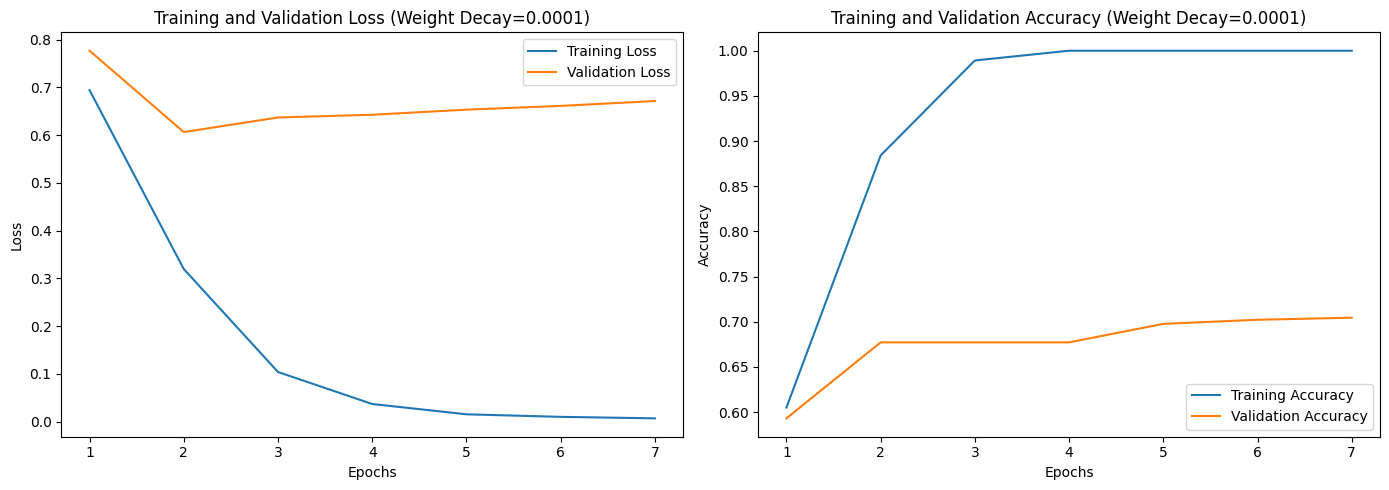

Evaluating on Test Data with weight_decay=0.0001...
Test Loss: 0.6422 - Test Accuracy: 0.6990

Running Experiment with weight_decay=1e-05, learning_rate=0.0001, batch_size=32
Epoch 1/20 - weight_decay=1e-05 - train_loss: 0.6874 - train_acc: 0.6040 - val_loss: 0.6493 - val_acc: 0.6727
Epoch 2/20 - weight_decay=1e-05 - train_loss: 0.2839 - train_acc: 0.9062 - val_loss: 0.6224 - val_acc: 0.6909
Epoch 3/20 - weight_decay=1e-05 - train_loss: 0.1010 - train_acc: 0.9943 - val_loss: 0.6182 - val_acc: 0.6909
Epoch 4/20 - weight_decay=1e-05 - train_loss: 0.0314 - train_acc: 1.0000 - val_loss: 0.6406 - val_acc: 0.6909
Epoch 5/20 - weight_decay=1e-05 - train_loss: 0.0155 - train_acc: 1.0000 - val_loss: 0.6298 - val_acc: 0.6955
Epoch 6/20 - weight_decay=1e-05 - train_loss: 0.0086 - train_acc: 1.0000 - val_loss: 0.6491 - val_acc: 0.6977
Epoch 7/20 - weight_decay=1e-05 - train_loss: 0.0060 - train_acc: 1.0000 - val_loss: 0.6519 - val_acc: 0.6864
Epoch 8/20 - weight_decay=1e-05 - train_loss: 0.0049 - 

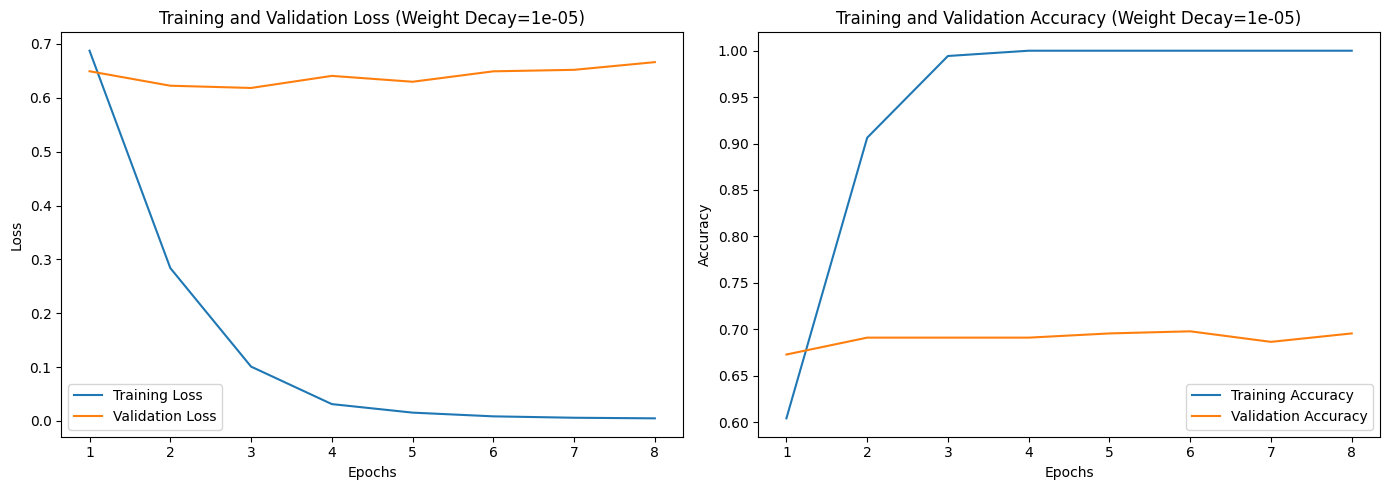

Evaluating on Test Data with weight_decay=1e-05...
Test Loss: 0.6299 - Test Accuracy: 0.7040

Running Experiment with weight_decay=1e-06, learning_rate=0.0001, batch_size=32
Epoch 1/20 - weight_decay=1e-06 - train_loss: 0.7066 - train_acc: 0.5875 - val_loss: 0.6579 - val_acc: 0.6432
Epoch 2/20 - weight_decay=1e-06 - train_loss: 0.3220 - train_acc: 0.8812 - val_loss: 0.6337 - val_acc: 0.6614
Epoch 3/20 - weight_decay=1e-06 - train_loss: 0.1175 - train_acc: 0.9864 - val_loss: 0.6208 - val_acc: 0.6977
Epoch 4/20 - weight_decay=1e-06 - train_loss: 0.0402 - train_acc: 1.0000 - val_loss: 0.6074 - val_acc: 0.7205
Epoch 5/20 - weight_decay=1e-06 - train_loss: 0.0169 - train_acc: 1.0000 - val_loss: 0.6190 - val_acc: 0.7182
Epoch 6/20 - weight_decay=1e-06 - train_loss: 0.0097 - train_acc: 1.0000 - val_loss: 0.6487 - val_acc: 0.7114
Epoch 7/20 - weight_decay=1e-06 - train_loss: 0.0068 - train_acc: 1.0000 - val_loss: 0.6384 - val_acc: 0.7205
Epoch 8/20 - weight_decay=1e-06 - train_loss: 0.0054 - t

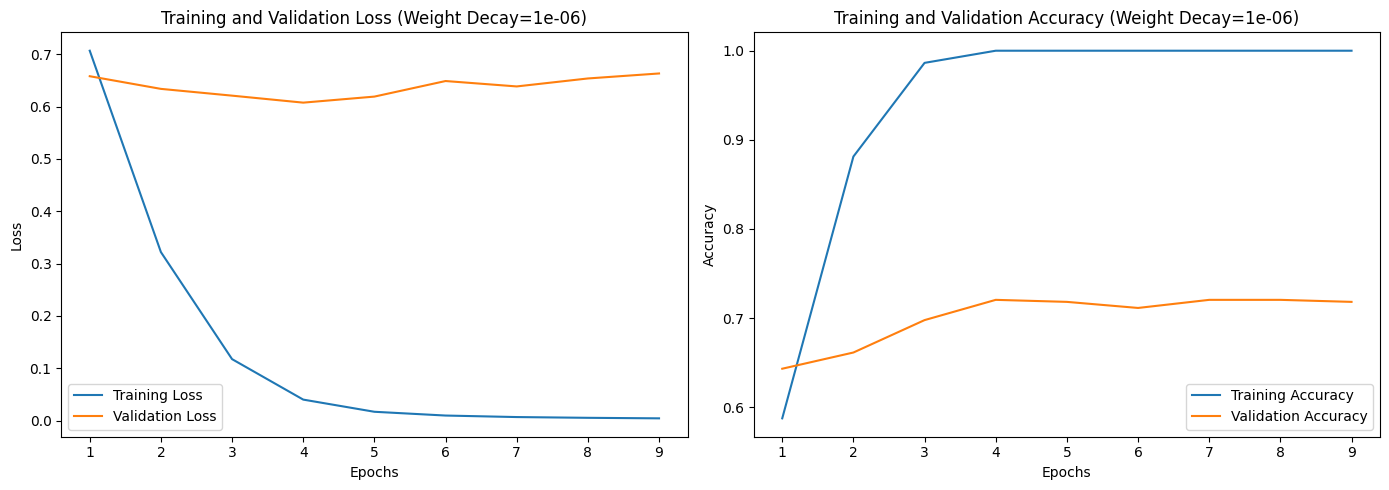

Evaluating on Test Data with weight_decay=1e-06...
Test Loss: 0.6491 - Test Accuracy: 0.6780


In [ ]:
# Experiment parameters
learning_rate = 0.0001
batch_size = 32
num_epochs = 20
early_stop_patience = 5
weight_decays = [1e-4, 1e-5, 1e-6]  # Different weight decay values for L2 Regularization

# Set DataLoaders for the current batch size
train_loader = train_loader_32
test_loader = test_loader_32
val_loader = val_loader_32

# Run experiments for different weight decay values
for weight_decay in weight_decays:
    print(f"\nRunning Experiment with weight_decay={weight_decay}, learning_rate={learning_rate}, batch_size={batch_size}")

    # Initialize model, loss, optimizer, and scheduler
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = SiameseNetwork().to(device)
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

    # Early stopping variables
    best_val_loss = float('inf')
    patience_counter = 0

    # Metrics for plotting
    training_losses, validation_losses = [], []
    training_accuracies, validation_accuracies = [], []

    # Start training
    start_time = time.time()
    for epoch in range(num_epochs):
        model.train()
        training_loss = 0
        training_correct = 0
        training_total = 0

        for img1, img2, label in train_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            optimizer.zero_grad()
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            loss.backward()
            optimizer.step()
            training_loss += loss.item()
            preds = (outputs >= 0.5).float()
            training_correct += (torch.flatten(preds) == label).float().sum()
            training_total += label.size(0)

        training_loss /= len(train_loader)
        training_accuracy = training_correct / len(train_loader.dataset)
        training_losses.append(training_loss)
        training_accuracies.append(training_accuracy.item())

        # Validation
        model.eval()
        validation_loss = 0
        validation_correct = 0
        validation_total = 0
        with torch.no_grad():
            for img1, img2, label in val_loader:
                img1, img2, label = img1.to(device), img2.to(device), label.to(device)
                outputs = model(img1, img2)
                loss = criterion(outputs.float(), label.unsqueeze(1).float())
                validation_loss += loss.item()
                preds = (outputs >= 0.5).float()
                validation_correct += (torch.flatten(preds) == label).float().sum()
                validation_total += label.size(0)

        validation_loss /= len(val_loader)
        validation_accuracy = validation_correct / len(val_loader.dataset)
        validation_losses.append(validation_loss)
        validation_accuracies.append(validation_accuracy.item())

        # Print metrics
        print(f"Epoch {epoch + 1}/{num_epochs} - weight_decay={weight_decay} - "
              f"train_loss: {training_loss:.4f} - train_acc: {training_accuracy:.4f} - "
              f"val_loss: {validation_loss:.4f} - val_acc: {validation_accuracy:.4f}")

        # Early stopping
        if validation_loss < best_val_loss:
            best_val_loss = validation_loss
            patience_counter = 0
            torch.save(model.state_dict(), f'siamese_best_model_weight_decay_32_{weight_decay}.pth')
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered!")
                break

        scheduler.step()

    end_time = time.time()
    print(f"Experiment with weight_decay={weight_decay} completed in {end_time - start_time:.2f} seconds")

    # Plot Results
    epochs = range(1, len(training_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Training and Validation Loss
    axes[0].plot(epochs, training_losses, label="Training Loss")
    axes[0].plot(epochs, validation_losses, label="Validation Loss")
    axes[0].set_title(f"Training and Validation Loss (Weight Decay={weight_decay})")
    axes[0].set_xlabel("Epochs")
    axes[0].set_ylabel("Loss")
    axes[0].legend()

    # Training and Validation Accuracy
    axes[1].plot(epochs, training_accuracies, label="Training Accuracy")
    axes[1].plot(epochs, validation_accuracies, label="Validation Accuracy")
    axes[1].set_title(f"Training and Validation Accuracy (Weight Decay={weight_decay})")
    axes[1].set_xlabel("Epochs")
    axes[1].set_ylabel("Accuracy")
    axes[1].legend()

    plt.tight_layout()
    plt.show()

    # Test Evaluation
    print(f"Evaluating on Test Data with weight_decay={weight_decay}...")
    model.eval()
    test_loss = 0
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for img1, img2, label in test_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            loss = criterion(outputs.float(), label.unsqueeze(1).float())
            test_loss += loss.item()
            preds = (outputs >= 0.5).float()
            test_correct += (torch.flatten(preds) == label).float().sum()
            test_total += label.size(0)

    test_loss /= len(test_loader)
    test_accuracy = test_correct / test_total

    print(f"Test Loss: {test_loss:.4f} - Test Accuracy: {test_accuracy:.4f}")


**best exp result:Running Experiment with weight_decay=0.0001, learning_rate=0.00001, batch_size=32**


True Positives: 363 examples


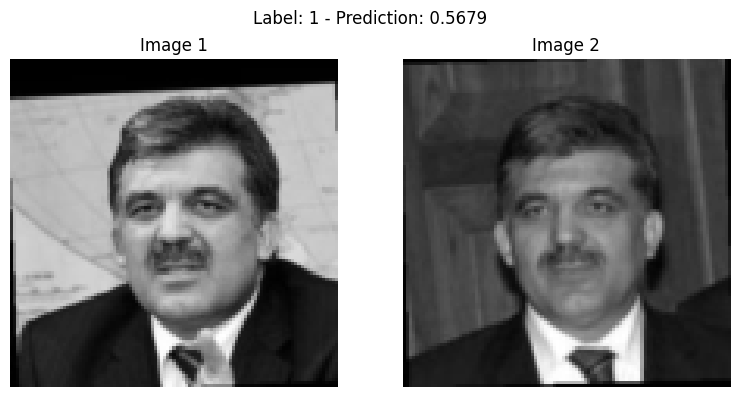


False Positives: 168 examples


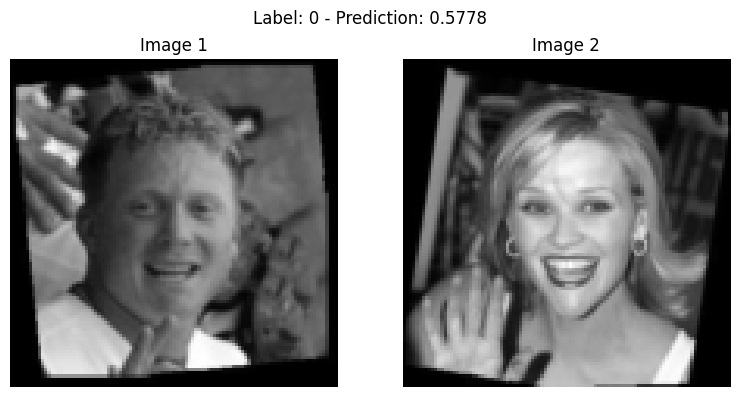


True Negatives: 332 examples


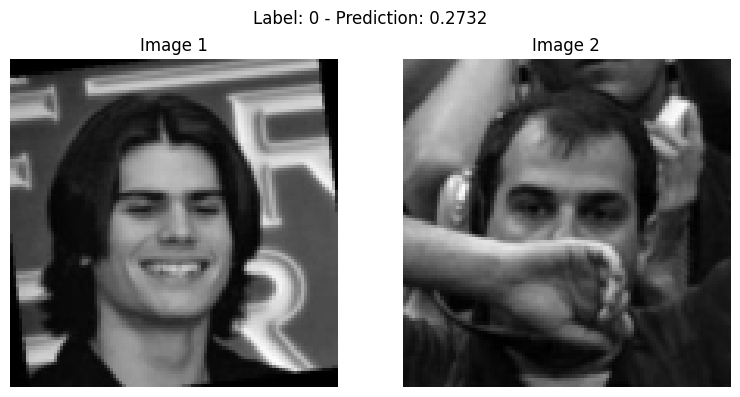


False Negatives: 137 examples


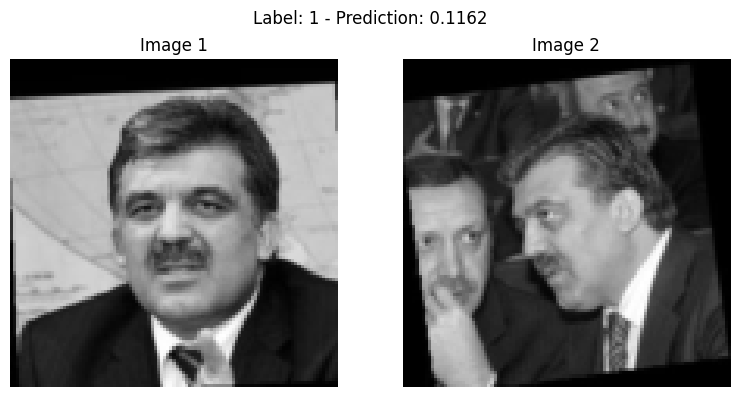

In [ ]:
# Function to get accurate and misclassified examples
def get_examples(model, data_loader, device):
    """
    Collect True Positive, False Positive, True Negative, and False Negative examples.
    """
    model.eval()
    true_positive, false_positive, true_negative, false_negative = [], [], [], []

    with torch.no_grad():
        for img1, img2, label in data_loader:
            img1, img2, label = img1.to(device), img2.to(device), label.to(device)
            outputs = model(img1, img2)
            preds = (outputs >= 0.5).float()

            for i in range(len(label)):
                if label[i] == 1 and preds[i] == 1:
                    true_positive.append((img1[i], img2[i], label[i], outputs[i]))
                elif label[i] == 0 and preds[i] == 1:
                    false_positive.append((img1[i], img2[i], label[i], outputs[i]))
                elif label[i] == 0 and preds[i] == 0:
                    true_negative.append((img1[i], img2[i], label[i], outputs[i]))
                elif label[i] == 1 and preds[i] == 0:
                    false_negative.append((img1[i], img2[i], label[i], outputs[i]))

    return true_positive, false_positive, true_negative, false_negative


# Function to display one example for a category
def display_examples(examples, title):
    """
    Display one example from a given category with clear labels.
    """
    print(f"\n{title}: {len(examples)} examples")
    if len(examples) > 0:
        img1, img2, label, output = examples[0]  # Take the first example
        img1, img2 = img1.cpu(), img2.cpu()

        # Convert tensors to PIL images
        transform_to_pil = transforms.ToPILImage()
        img1_pil = transform_to_pil(img1.squeeze(0))
        img2_pil = transform_to_pil(img2.squeeze(0))

        # Display images and prediction details
        plt.figure(figsize=(8, 4))

        # Image 1
        plt.subplot(1, 2, 1)
        plt.imshow(img1_pil, cmap="gray")
        plt.axis("off")
        plt.title("Image 1")

        # Image 2
        plt.subplot(1, 2, 2)
        plt.imshow(img2_pil, cmap="gray")
        plt.axis("off")
        plt.title("Image 2")

        # Overall title
        plt.suptitle(f"Label: {label.item()} - Prediction: {output.item():.4f}", fontsize=12)

        plt.tight_layout()  # Prevent overlapping
        plt.show()
    else:
        print("No examples available in this category.")



# Load your trained model and DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SiameseNetwork().to(device)
state_dict = torch.load("/content/siamese_best_model_weight_decay_32_1e-05.pth", weights_only=True) # Best model path
model.load_state_dict(state_dict)
model.eval()

# Assuming 'test_loader' is your DataLoader for test data
true_positive, false_positive, true_negative, false_negative = get_examples(model, test_loader, device)

# Display one example for each category
display_examples(true_positive, "True Positives")
display_examples(false_positive, "False Positives")
display_examples(true_negative, "True Negatives")
display_examples(false_negative, "False Negatives")
